# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Baseline, nothing exluded.

Like MLP_265 with class weight.

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-15 17:50:58.150486


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
#EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
EXCLUSIONS = [0,2,3,4,5,6,7,8,9,10,11,12,13,14]   # use only H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_271'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-15 17:51:33.003620
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd )  # no validation )
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-15 17:51:34.418694
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 2982
Num RCI: 2982
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 2982 sequences.

Training # 1 1
2023-04-15 17:51:52.227671
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-15 17:51:52.473143
Discriminator is GMM
Means [-1.4457786698356236, 0.4066210490827031]
Variances [1.62452897 1.60011338]
Priors [0.43592685 0.56407315]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1434:945 60.28%
Computed class weights: {0: 1.2587301587301587, 1: 0.8294979079497908}
Valid 1:0 351:252 58.21%
FIT
2023-04-15 17:51:53.791896


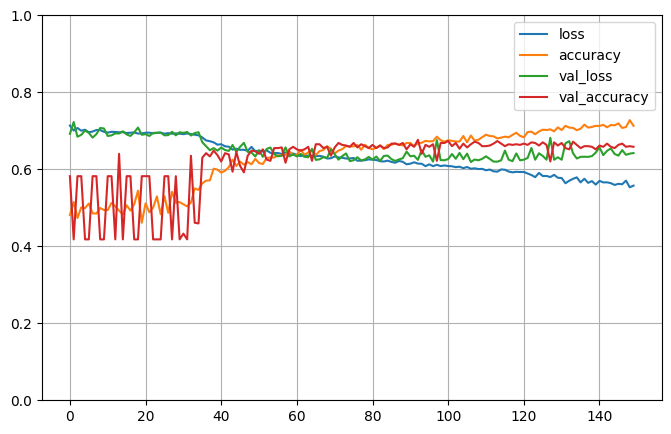


Testing # 1 1
2023-04-15 17:53:05.348909
2023-04-15 17:53:05.348963
PREDICT
2023-04-15 17:53:05.357482
Test 1:0 351:252 58.21%
Predict 1:0 379:224 62.85%
Test sizes (603, 1025) (603,)
Distrib of scores: 0.5544586 mean 0.22846626 std
Range of scores: 0.008519773 to 0.9297967
Score threshold 0.5
Confusion matrix
 [[135 117]
 [ 89 262]]
Normalized matrix
 [[0.2238806  0.19402985]
 [0.14759536 0.4344942 ]]
Extreme scores correct, pos:neg 190 84
Extreme scores incorrect pos:neg 65 48


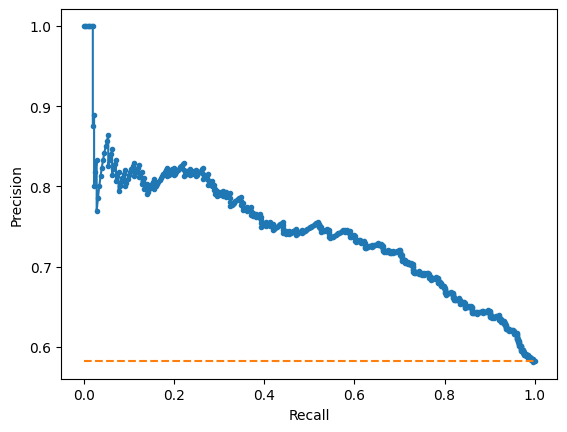

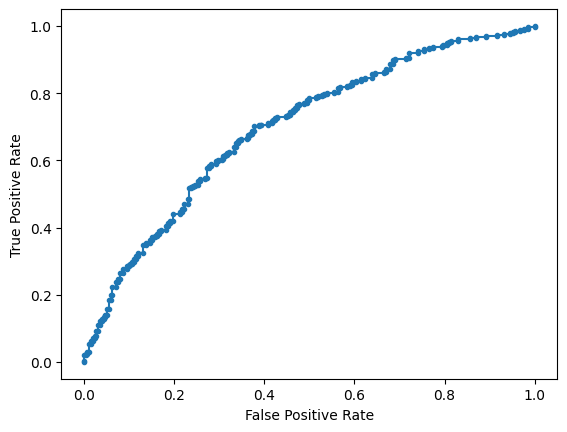

Accuracy: 65.84% Precision: 69.13% Recall: 74.64%
F1: 71.78% MCC: 0.2880
AUPRC: 74.35% AUROC: 69.66%
 accuracy [65.83747927031509]
 precision [69.12928759894459]
 recall [74.64387464387464]
 F1 [71.78082191780821]
 MCC [0.2880016237027306]
 AUPRC [74.35071823109831]
 AUROC [69.661511328178]

Training # 1 2
2023-04-15 17:53:06.316730
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-15 17:53:06.564615
Discriminator is GMM
Means [0.39321351620723277, -1.4152915682536868]
Variances [1.59437221 1.57420958]
Priors [0.55568081 0.44431919]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1391:998 58.23%
Computed class weights: {0: 1.1968937875751502, 1: 0.8587347232207045}
Valid 1:0 351:242 59.19%
FIT
2023-04-15 17:53:08.468196


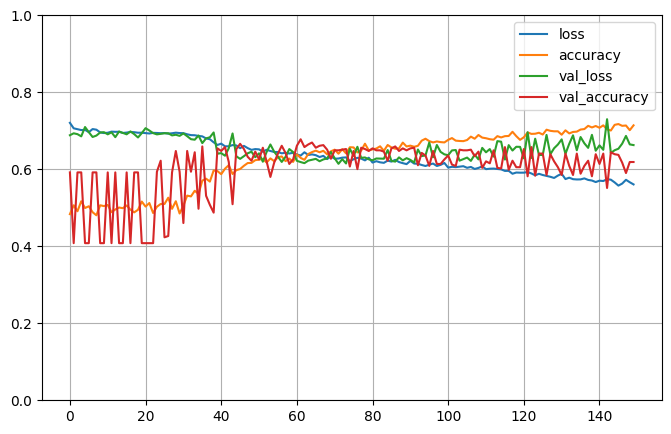


Testing # 1 2
2023-04-15 17:54:31.784450
2023-04-15 17:54:31.784802
PREDICT
2023-04-15 17:54:31.794240
Test 1:0 351:242 59.19%
Predict 1:0 351:242 59.19%
Test sizes (593, 1025) (593,)
Distrib of scores: 0.52482575 mean 0.22112106 std
Range of scores: 0.03308922 to 0.98951626
Score threshold 0.5
Confusion matrix
 [[129 113]
 [113 238]]
Normalized matrix
 [[0.21753794 0.19055649]
 [0.19055649 0.40134907]]
Extreme scores correct, pos:neg 143 88
Extreme scores incorrect pos:neg 61 63


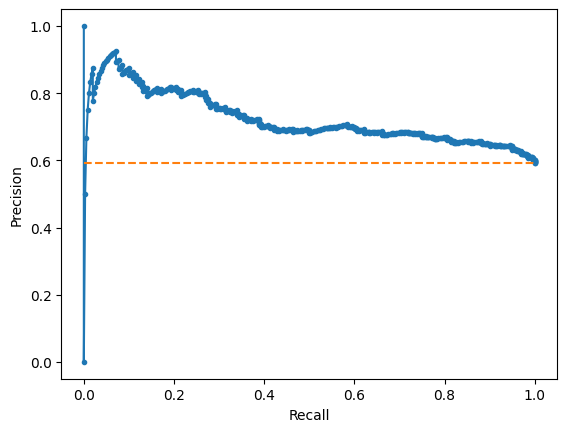

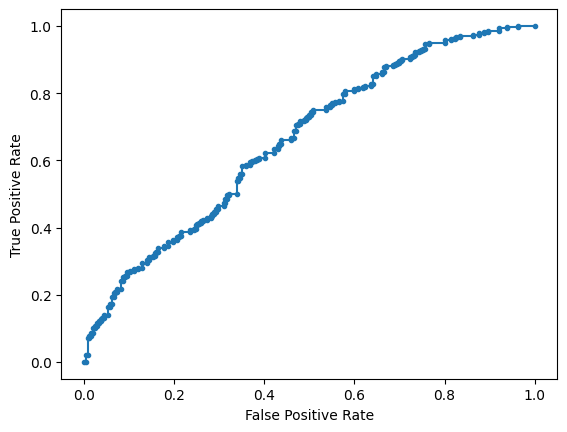

Accuracy: 61.89% Precision: 67.81% Recall: 67.81%
F1: 67.81% MCC: 0.2111
AUPRC: 72.16% AUROC: 65.99%
 accuracy [61.88870151770658]
 precision [67.80626780626781]
 recall [67.80626780626781]
 F1 [67.80626780626781]
 MCC [0.21112052930234748]
 AUPRC [72.15650475703279]
 AUROC [65.9885568976478]

Training # 1 3
2023-04-15 17:54:32.677180
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-15 17:54:32.948375
Discriminator is GMM
Means [0.40907207689802794, -1.465289302586859]
Variances [1.51550776 1.51368463]
Priors [0.5713906 0.4286094]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1461:939 60.88%
Computed class weights: {0: 1.2779552715654952, 1: 0.8213552361396304}
Valid 1:0 331:251 56.87%
FIT
2023-04-15 17:54:34.304112


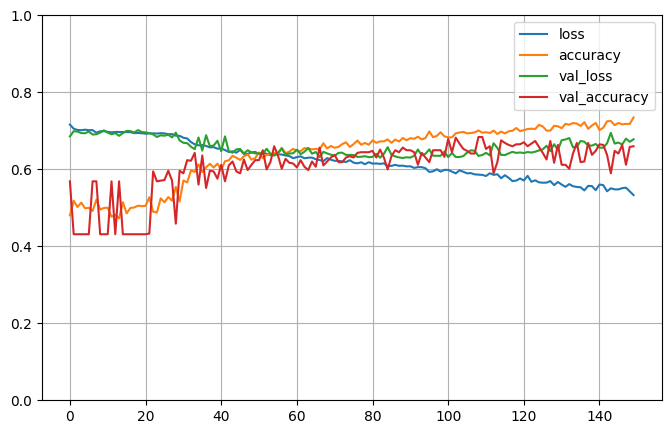


Testing # 1 3
2023-04-15 17:56:00.665959
2023-04-15 17:56:00.666371
PREDICT
2023-04-15 17:56:00.671490
Test 1:0 331:251 56.87%
Predict 1:0 405:177 69.59%
Test sizes (582, 1025) (582,)
Distrib of scores: 0.61097693 mean 0.23257115 std
Range of scores: 0.034122687 to 0.9796385
Score threshold 0.5
Confusion matrix
 [[115 136]
 [ 62 269]]
Normalized matrix
 [[0.1975945  0.23367698]
 [0.10652921 0.46219931]]
Extreme scores correct, pos:neg 202 65
Extreme scores incorrect pos:neg 96 27


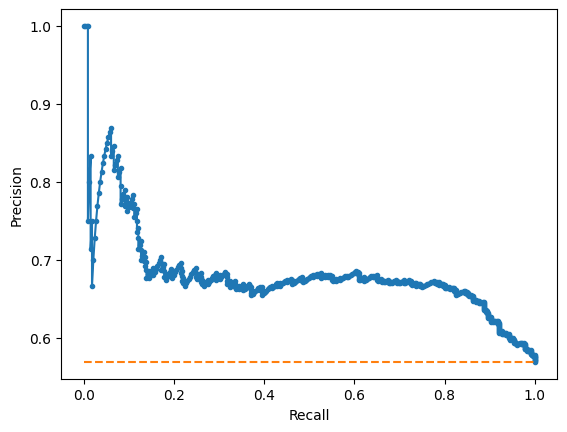

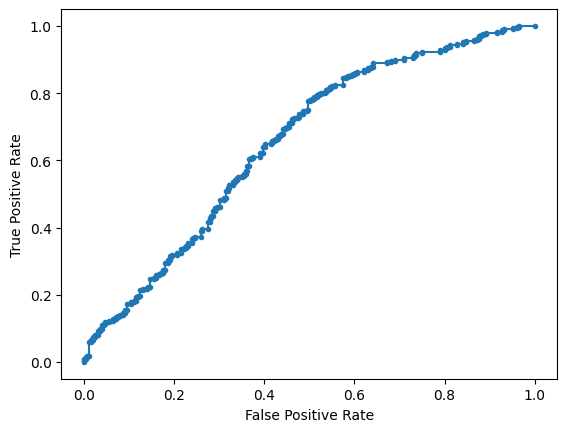

Accuracy: 65.98% Precision: 66.42% Recall: 81.27%
F1: 73.10% MCC: 0.2916
AUPRC: 68.12% AUROC: 65.37%
 accuracy [65.97938144329896]
 precision [66.41975308641975]
 recall [81.2688821752266]
 F1 [73.09782608695652]
 MCC [0.29159187450156077]
 AUPRC [68.12185421363598]
 AUROC [65.36994017886158]

Training # 1 4
2023-04-15 17:56:01.273259
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-15 17:56:01.480147
Discriminator is GMM
Means [0.41245694768976, -1.4630061329303885]
Variances [1.56688899 1.58956394]
Priors [0.5668711 0.4331289]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1433:950 60.13%
Computed class weights: {0: 1.2542105263157894, 1: 0.8314724354501046}
Valid 1:0 358:241 59.77%
FIT
2023-04-15 17:56:02.672060


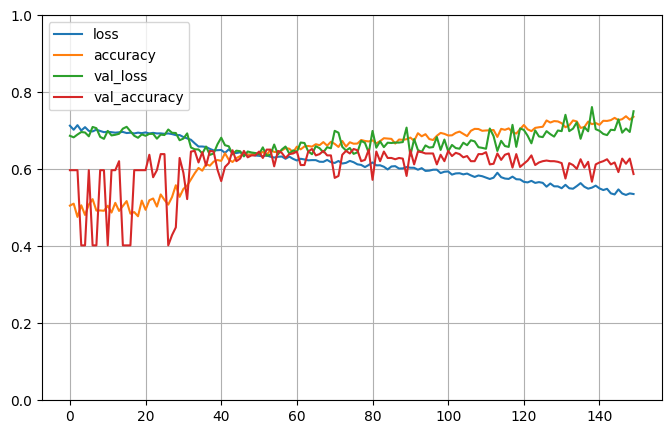


Testing # 1 4
2023-04-15 17:57:25.958034
2023-04-15 17:57:25.958085
PREDICT
2023-04-15 17:57:25.962118
Test 1:0 358:241 59.77%
Predict 1:0 295:304 49.25%
Test sizes (599, 1025) (599,)
Distrib of scores: 0.47174123 mean 0.2505265 std
Range of scores: 0.0038126484 to 0.9778286
Score threshold 0.5
Confusion matrix
 [[149  92]
 [155 203]]
Normalized matrix
 [[0.24874791 0.15358932]
 [0.25876461 0.33889816]]
Extreme scores correct, pos:neg 120 110
Extreme scores incorrect pos:neg 53 94


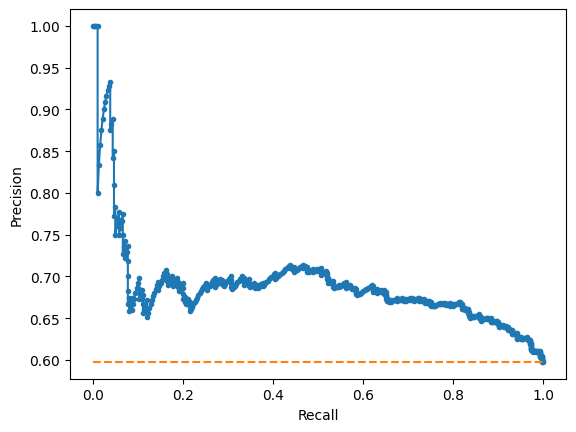

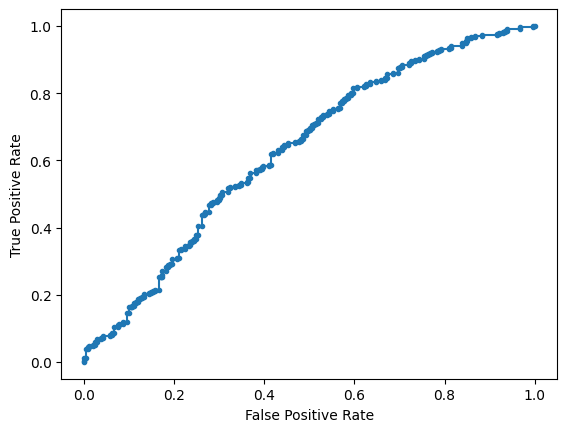

Accuracy: 58.76% Precision: 68.81% Recall: 56.70%
F1: 62.17% MCC: 0.1817
AUPRC: 68.97% AUROC: 63.02%
 accuracy [58.764607679465776]
 precision [68.8135593220339]
 recall [56.70391061452514]
 F1 [62.17457886676876]
 MCC [0.18174779079032385]
 AUPRC [68.97015101393316]
 AUROC [63.02185957022647]

Training # 1 5
2023-04-15 17:57:26.637817
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-15 17:57:26.856296
Discriminator is GMM
Means [0.36204973671170776, -1.488985980127083]
Variances [1.48007307 1.57031374]
Priors [0.56444287 0.43555713]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1418:959 59.66%
Computed class weights: {0: 1.2393117831074036, 1: 0.8381523272214386}
Valid 1:0 392:213 64.79%
FIT
2023-04-15 17:57:28.023865


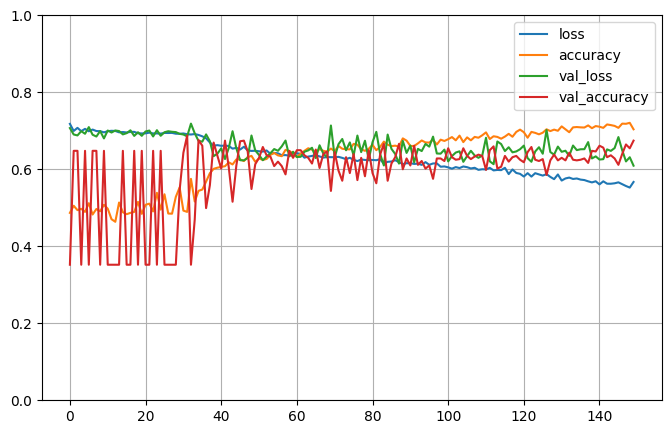


Testing # 1 5
2023-04-15 17:58:51.332746
2023-04-15 17:58:51.332807
PREDICT
2023-04-15 17:58:51.338961
Test 1:0 392:213 64.79%
Predict 1:0 451:154 74.55%
Test sizes (605, 1025) (605,)
Distrib of scores: 0.6253632 mean 0.20823218 std
Range of scores: 0.030059515 to 0.9293196
Score threshold 0.5
Confusion matrix
 [[ 85 128]
 [ 69 323]]
Normalized matrix
 [[0.14049587 0.21157025]
 [0.11404959 0.5338843 ]]
Extreme scores correct, pos:neg 248 51
Extreme scores incorrect pos:neg 86 30


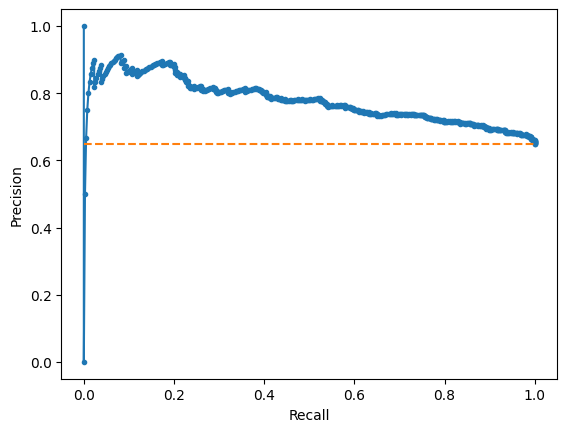

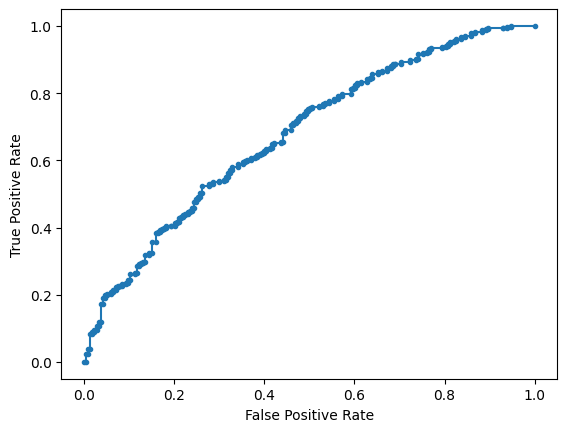

Accuracy: 67.44% Precision: 71.62% Recall: 82.40%
F1: 76.63% MCC: 0.2446
AUPRC: 77.63% AUROC: 67.63%
 accuracy [67.43801652892562]
 precision [71.61862527716187]
 recall [82.39795918367348]
 F1 [76.63107947805456]
 MCC [0.24455028691116312]
 AUPRC [77.63449167690392]
 AUROC [67.62599405959566]

Training # 2 1
2023-04-15 17:58:51.984155
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-15 17:58:52.219315
Discriminator is GMM
Means [0.4251310296777448, -1.464353283811784]
Variances [1.48626079 1.44551628]
Priors [0.5720307 0.4279693]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1437:941 60.43%
Computed class weights: {0: 1.2635494155154092, 1: 0.8274182324286709}
Valid 1:0 347:257 57.45%
FIT
2023-04-15 17:58:53.377559


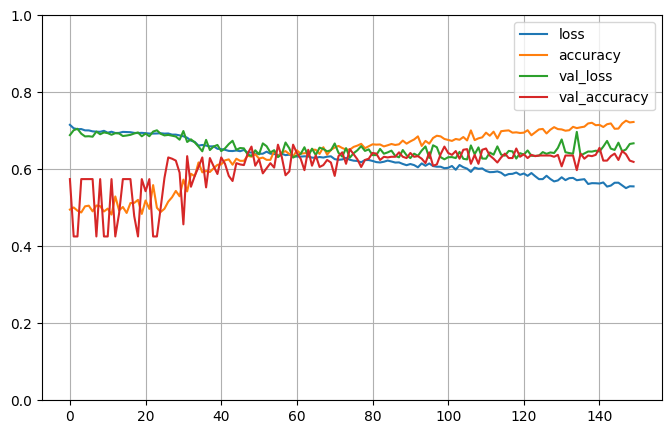


Testing # 2 1
2023-04-15 18:00:04.137110
2023-04-15 18:00:04.137158
PREDICT
2023-04-15 18:00:04.141735
Test 1:0 347:257 57.45%
Predict 1:0 325:279 53.81%
Test sizes (604, 1025) (604,)
Distrib of scores: 0.49373308 mean 0.22802566 std
Range of scores: 0.0055291965 to 0.9291688
Score threshold 0.5
Confusion matrix
 [[153 104]
 [126 221]]
Normalized matrix
 [[0.25331126 0.17218543]
 [0.20860927 0.36589404]]
Extreme scores correct, pos:neg 131 111
Extreme scores incorrect pos:neg 48 67


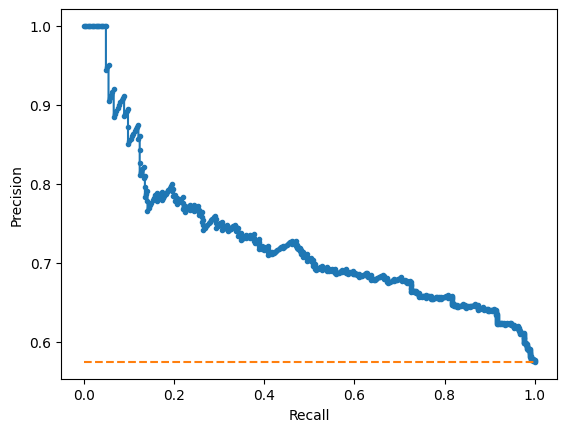

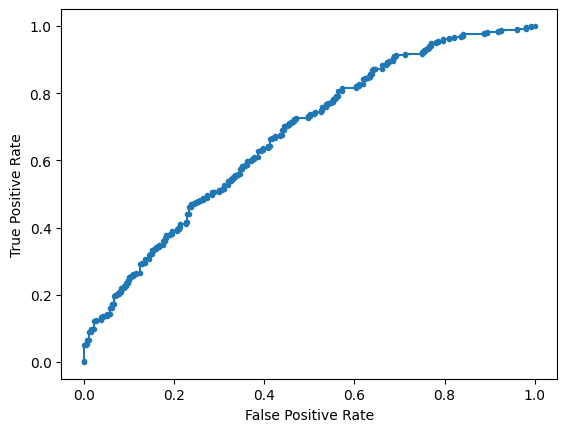

Accuracy: 61.92% Precision: 68.00% Recall: 63.69%
F1: 65.77% MCC: 0.2303
AUPRC: 72.73% AUROC: 67.36%
 accuracy [61.920529801324506]
 precision [68.0]
 recall [63.68876080691642]
 F1 [65.77380952380952]
 MCC [0.23029475498425]
 AUPRC [72.72697373895281]
 AUROC [67.36339272698729]

Training # 2 2
2023-04-15 18:00:04.761795
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-15 18:00:05.016520
Discriminator is GMM
Means [0.3724246455927556, -1.5122954038128853]
Variances [1.54849273 1.52891538]
Priors [0.57970328 0.42029672]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1478:914 61.79%
Computed class weights: {0: 1.3085339168490153, 1: 0.8092016238159675}
Valid 1:0 364:226 61.69%
FIT
2023-04-15 18:00:06.227608


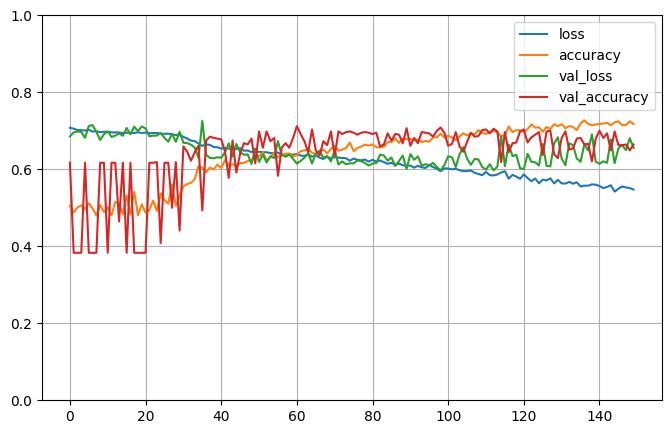


Testing # 2 2
2023-04-15 18:01:30.081205
2023-04-15 18:01:30.081610
PREDICT
2023-04-15 18:01:30.088028
Test 1:0 364:226 61.69%
Predict 1:0 314:276 53.22%
Test sizes (590, 1025) (590,)
Distrib of scores: 0.500623 mean 0.23481496 std
Range of scores: 0.01466276 to 0.9495989
Score threshold 0.5
Confusion matrix
 [[152  74]
 [124 240]]
Normalized matrix
 [[0.25762712 0.12542373]
 [0.21016949 0.40677966]]
Extreme scores correct, pos:neg 158 109
Extreme scores incorrect pos:neg 44 62


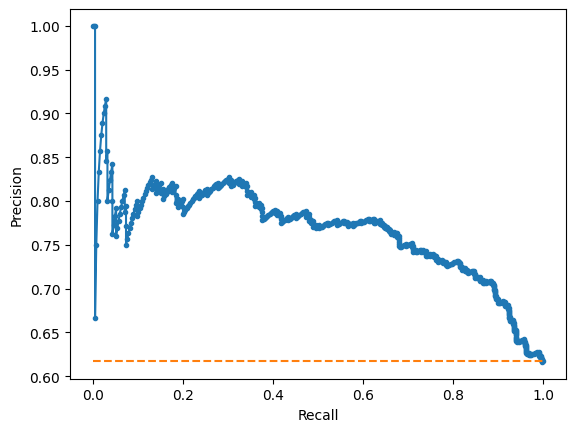

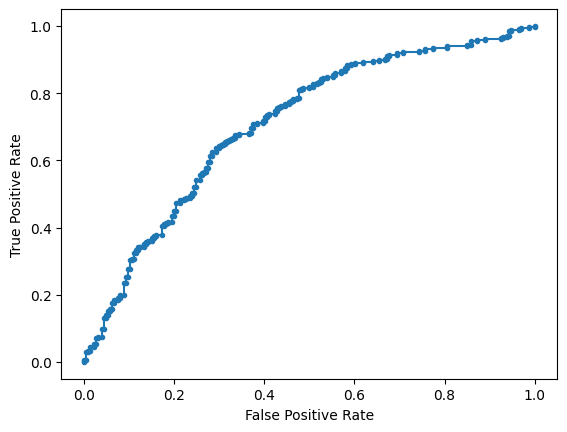

Accuracy: 66.44% Precision: 76.43% Recall: 65.93%
F1: 70.80% MCC: 0.3234
AUPRC: 76.61% AUROC: 70.90%
 accuracy [66.44067796610169]
 precision [76.43312101910828]
 recall [65.93406593406593]
 F1 [70.79646017699113]
 MCC [0.32337169182446773]
 AUPRC [76.61389706403759]
 AUROC [70.90221725177479]

Training # 2 3
2023-04-15 18:01:30.993978
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-15 18:01:31.203176
Discriminator is GMM
Means [0.40555670122899445, -1.4433631537163252]
Variances [1.5181444  1.62442123]
Priors [0.55511268 0.44488732]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1390:994 58.31%
Computed class weights: {0: 1.199195171026157, 1: 0.8575539568345324}
Valid 1:0 364:234 60.87%
FIT
2023-04-15 18:01:34.116181


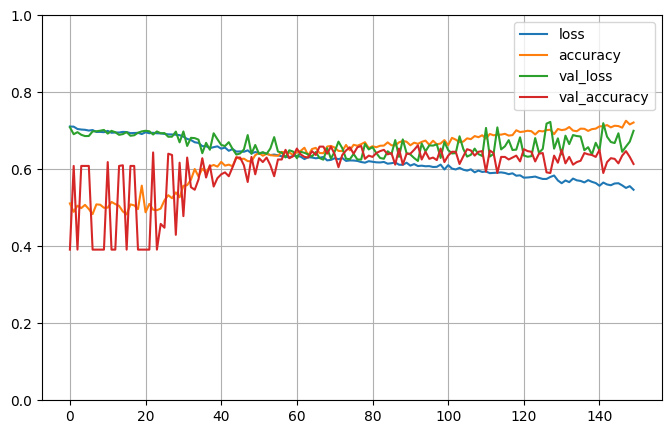


Testing # 2 3
2023-04-15 18:02:47.173331
2023-04-15 18:02:47.173378
PREDICT
2023-04-15 18:02:47.177773
Test 1:0 364:234 60.87%
Predict 1:0 295:303 49.33%
Test sizes (598, 1025) (598,)
Distrib of scores: 0.47923157 mean 0.23697546 std
Range of scores: 0.015467162 to 0.97494125
Score threshold 0.5
Confusion matrix
 [[153  81]
 [150 214]]
Normalized matrix
 [[0.25585284 0.13545151]
 [0.25083612 0.35785953]]
Extreme scores correct, pos:neg 129 104
Extreme scores incorrect pos:neg 40 88


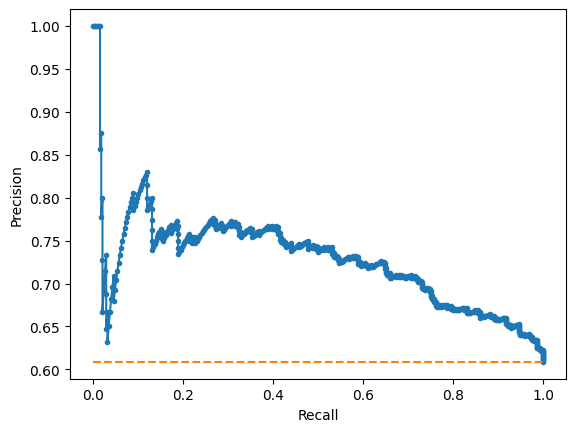

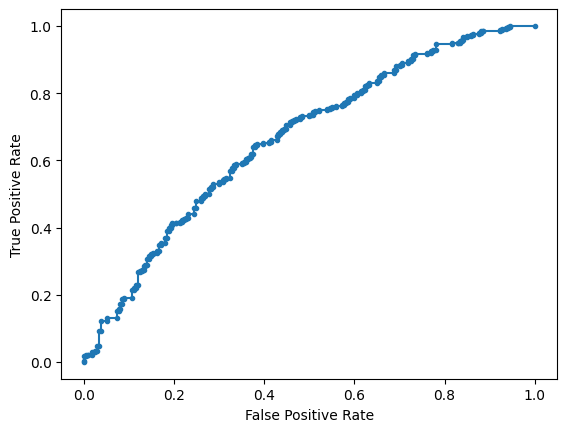

Accuracy: 61.37% Precision: 72.54% Recall: 58.79%
F1: 64.95% MCC: 0.2360
AUPRC: 72.72% AUROC: 66.43%
 accuracy [61.37123745819398]
 precision [72.54237288135593]
 recall [58.791208791208796]
 F1 [64.94688922610014]
 MCC [0.23599760021566746]
 AUPRC [72.71548668093956]
 AUROC [66.42833662064432]

Training # 2 4
2023-04-15 18:02:47.802476
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-15 18:02:48.023280
Discriminator is GMM
Means [-1.4178979705195447, 0.39872987653846226]
Variances [1.6257418  1.60495034]
Priors [0.44506989 0.55493011]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1403:998 58.43%
Computed class weights: {0: 1.2029058116232465, 1: 0.8556664290805417}
Valid 1:0 345:236 59.38%
FIT
2023-04-15 18:02:49.232642


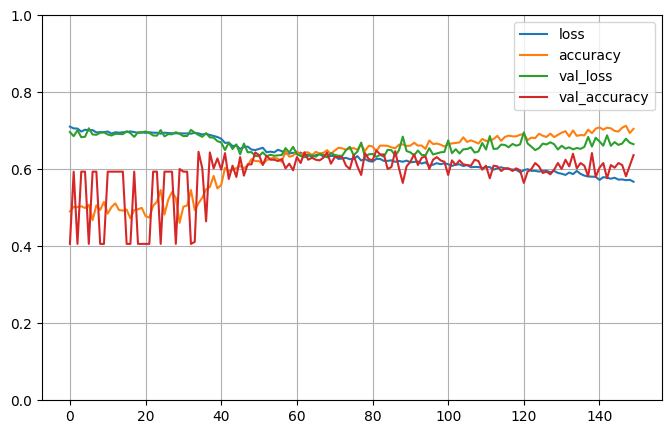


Testing # 2 4
2023-04-15 18:04:12.527453
2023-04-15 18:04:12.527500
PREDICT
2023-04-15 18:04:12.536104
Test 1:0 345:236 59.38%
Predict 1:0 434:147 74.70%
Test sizes (581, 1025) (581,)
Distrib of scores: 0.62728983 mean 0.20882411 std
Range of scores: 0.050597403 to 0.9725539
Score threshold 0.5
Confusion matrix
 [[ 86 150]
 [ 61 284]]
Normalized matrix
 [[0.14802065 0.25817556]
 [0.10499139 0.48881239]]
Extreme scores correct, pos:neg 212 54
Extreme scores incorrect pos:neg 113 21


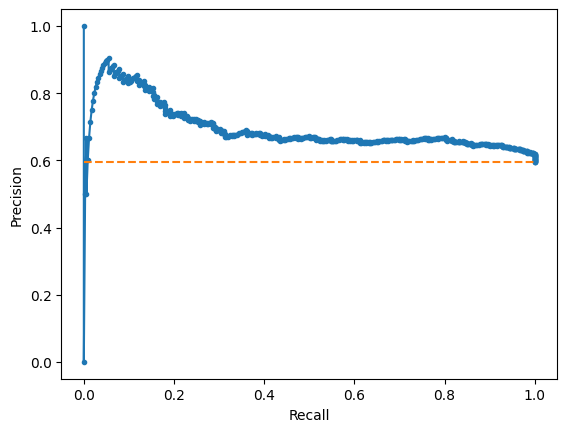

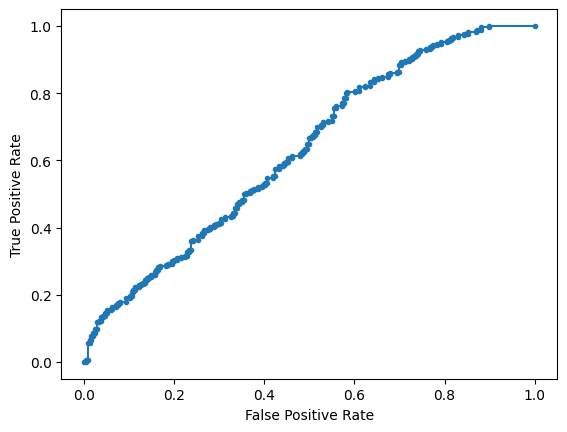

Accuracy: 63.68% Precision: 65.44% Recall: 82.32%
F1: 72.91% MCC: 0.2119
AUPRC: 69.34% AUROC: 62.84%
 accuracy [63.683304647160064]
 precision [65.43778801843318]
 recall [82.31884057971014]
 F1 [72.91399229781771]
 MCC [0.2119257384471551]
 AUPRC [69.34166553396072]
 AUROC [62.83714075165807]

Training # 2 5
2023-04-15 18:04:13.131490
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-15 18:04:13.373056
Discriminator is GMM
Means [0.3530356654919976, -1.489292428277836]
Variances [1.60652301 1.61718002]
Priors [0.58078045 0.41921955]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Train 1:0 1475:898 62.16%
Computed class weights: {0: 1.3212694877505569, 1: 0.8044067796610169}
Valid 1:0 385:224 63.22%
FIT
2023-04-15 18:04:14.566056


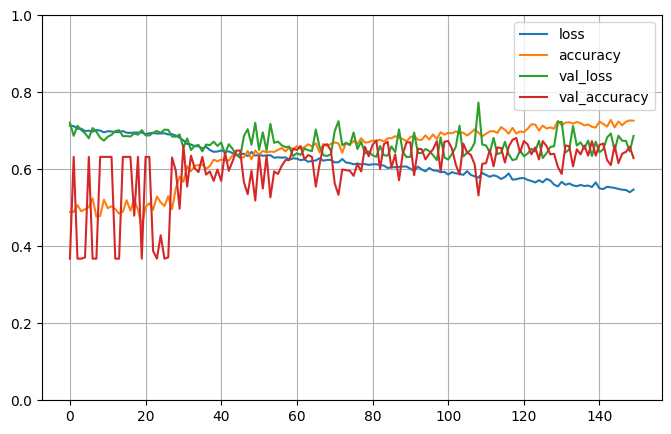


Testing # 2 5
2023-04-15 18:05:25.402198
2023-04-15 18:05:25.402606
PREDICT
2023-04-15 18:05:25.411033
Test 1:0 385:224 63.22%
Predict 1:0 333:276 54.68%
Test sizes (609, 1025) (609,)
Distrib of scores: 0.5010371 mean 0.23343599 std
Range of scores: 0.02042575 to 0.9639519
Score threshold 0.5
Confusion matrix
 [[137  87]
 [139 246]]
Normalized matrix
 [[0.22495895 0.14285714]
 [0.22824302 0.40394089]]
Extreme scores correct, pos:neg 148 101
Extreme scores incorrect pos:neg 41 78


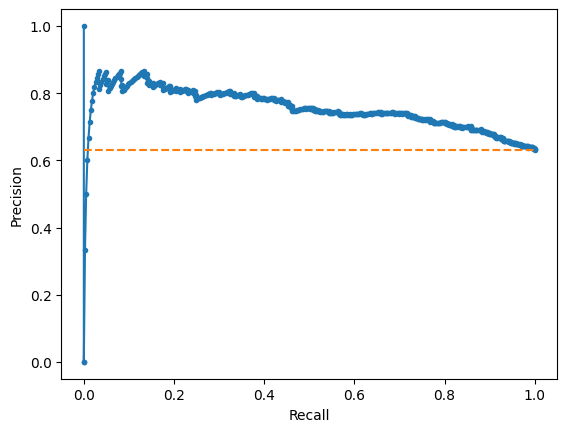

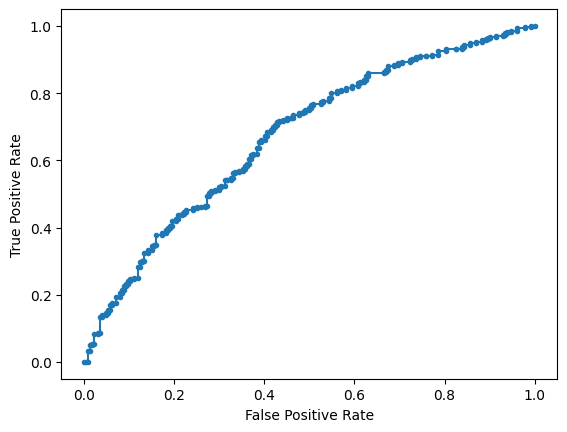

Accuracy: 62.89% Precision: 73.87% Recall: 63.90%
F1: 68.52% MCC: 0.2427
AUPRC: 75.37% AUROC: 67.14%
 accuracy [62.88998357963875]
 precision [73.87387387387388]
 recall [63.896103896103895]
 F1 [68.52367688022284]
 MCC [0.24271892378656099]
 AUPRC [75.36614176125059]
 AUROC [67.13821892393321]
2023-04-15 18:05:26.032201


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 63.62% std 2.75
 precision mean 70.01% std 3.50
 recall mean 69.74% std 9.74
 F1 mean 69.44% std 4.40
 MCC mean 0.2461 std 0.0431
 AUPRC mean 72.80% std 3.26
 AUROC mean 66.63% std 2.55
 accuracy [[65.83747927031509], [61.88870151770658], [65.97938144329896], [58.764607679465776], [67.43801652892562], [61.920529801324506], [66.44067796610169], [61.37123745819398], [63.683304647160064], [62.88998357963875]]
 precision [[69.12928759894459], [67.80626780626781], [66.41975308641975], [68.8135593220339], [71.61862527716187], [68.0], [76.43312101910828], [72.54237288135593], [65.43778801843318], [73.87387387387388]]
 recall [[74.64387464387464], [67.80626780626781], [81.2688821752266], [56.70391061452514], [82.39795918367348], [63.68876080691642], [65.93406593406593], [58.791208791208796], [82.31884057971014], [63.896103896103895]]
 F1 [[71.78082191780821], [67.80626780626781], [73.09782608695652], [62.17457886676876], [76.63107947805456], [65.77380952380952], [70.796460176991